In [1]:
import numpy as np
from matplotlib import pyplot as plt

from ase.io import read
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal

from scipy.optimize import minimize

from dftpy.ions import Ions
from dftpy.functional import Functional
from dftpy.formats import io
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.optimization import Optimization

from ase.build import bulk


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


In [3]:
path_pp='/Users/valeria/Documents/PP/ofpp/EAC/upf/blps/'
file='si.lda.upf'
PP_list = {'Si': path_pp+file}

In [4]:
def min_delta_rho(x0, *args):
    rho_ks, ions = args
    KE = Functional(type='KEDF',name='WT', rho0=x0)
    ions.set_charges(4)
    grid = DirectGrid(lattice=ions.cell, nr=[len(rho_ks),len(rho_ks),len(rho_ks[0,0])])
    rho_ini = DirectField(grid=grid)
    rho_ini[:] = ions.get_ncharges()/ions.cell.volume
    PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
    evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
    optimization_options = {'econv' : 1e-5*ions.nat}
    opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, 
                       optimization_method = 'TN')
    rho = opt.optimize_rho(guess_rho=rho_ini)
    rho_ini[:]=rho
    diff = 0.5 * (np.abs(rho - rho_ks)).integral()
    print('difference: ', diff)
    return diff

In [5]:
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')
l = np.linspace(0.8, 1.4, 30)
delta_rho = []
R0 = []
vol = []
for n in np.arange(0,30,1):
    print('NEW STRUCTURE')
    i = int(n)
    rho_ks = io.read_density('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_fcc/DATA2/rho0'+str(i)+'.xsf')
    ions = Ions.from_ase(bulk('Si', 'fcc', a= 3.405, cubic=True))
    cell = ions.get_cell()
    ions.set_cell(cell * l[i], scale_atoms=True) 
    minn = minimize(min_delta_rho, 0.01, args = (rho_ks, ions), method='Powell', bounds=[[0,11]], options={'ftol' : 1e-2})
    vol.append(ions.get_volume())
    delta_rho.append(minn.fun)
    R0.append(minn.x)

NEW STRUCTURE
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -1.262650983014E+01     -1.262651E+01   8.746053E+00    1       1       1.179368E-01    
1       -1.446038522733E+01     -1.833875E+00   6.390540E-01    11      2       2.321527E-01    
2       -1.447392191128E+01     -1.353668E-02   5.603849E-02    6       1       2.818377E-01    
3       -1.447663651783E+01     -2.714607E-03   2.281198E-03    9       1       3.478060E-01    
4       -1.447671123211E+01     -7.471428E-05   2.164086E-04    6       1       3.873138E-01    
5       -1.447672389171E+01     -1.265960E-05   2.002203E-05    11      1       4.569948E-01    
6       -1.447672466173E+01     -7.700261E-07   1.779841E-06    9       1       4.924757E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 1.2010116801809319
Chemical potential (eV)  : 32.68119244917723
di

Text(0, 0.5, '$ρ_{0}$')

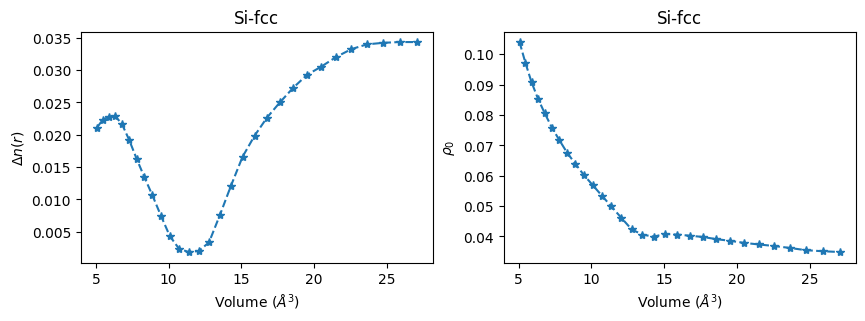

In [8]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
im0 = axs[0].plot(np.asarray(vol)*0.529177**3/4,np.asarray(delta_rho)*1/4,'*--')
im1 = axs[1].plot(np.asarray(vol)*0.529177**3/4,np.asarray(R0),'*--')
axs[0].set_title('Si-fcc')
axs[1].set_title('Si-fcc')
axs[0].set_xlabel('Volume ($\AA^{3}$)')
axs[0].set_ylabel('$\Delta n(r)$')
axs[1].set_xlabel('Volume ($\AA^{3}$)')
axs[1].set_ylabel('$\u03C1_{0}$')

In [9]:
np.save('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_fcc/DATA2/rho0_dDEN', np.asarray(R0))